# Task 2: User Engagement Analysis

##  Import Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
from sqlalchemy import create_engine
os.chdir('..')
from Db_connection.connection import PostgresConnection
from src.utils import *


Connected to PostgreSQL database!
Connection closed.


## Connect To PostgreSQL Database

In [3]:
db = PostgresConnection(dbname='telecom', user='postgres', password='postgres')
db.connect()

# Query the table to verify the write
query = "SELECT * FROM xdr_data_cleaned"
result = db.execute_query(query)

# Convert result to a DataFrame and display the information
df_cleaned = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df_cleaned.head())

# Close the connection
db.close_connection()

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

## Aggregate Metrics per Customer ID (MSISDN)

In [5]:
# Define DL and UL columns
dl_columns = [
    'Social Media DL (Bytes)', 
    'Google DL (Bytes)', 
    'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 
    'Netflix DL (Bytes)', 
    'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

ul_columns = [
    'Social Media UL (Bytes)', 
    'Google UL (Bytes)', 
    'Email UL (Bytes)', 
    'Youtube UL (Bytes)', 
    'Netflix UL (Bytes)', 
    'Gaming UL (Bytes)', 
    'Other UL (Bytes)'
]

agg_data = df_cleaned.groupby('MSISDN/Number').agg(
    sessions_frequency=('Bearer Id', 'count'),
    total_duration=('Dur. (ms)', 'sum'),
    **{col: (col, 'sum') for col in dl_columns},  # Sum each DL column
    **{col: (col, 'sum') for col in ul_columns}   # Sum each UL column
)

# Calculate total data volume
agg_data['total_traffic'] = agg_data[dl_columns].sum(axis=1) + agg_data[ul_columns].sum(axis=1)

# Drop the intermediary columns
agg_data = agg_data.drop(columns=dl_columns + ul_columns)

# Top 10 customers per engagement metric
top_sessions = agg_data.nlargest(10, 'sessions_frequency')
top_duration = agg_data.nlargest(10, 'total_duration')
top_traffic = agg_data.nlargest(10, 'total_traffic')

print(top_sessions)
print(top_duration)
print(top_traffic)

               sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
3.362632e+10                   18       8791927.0   1.599664e+10
3.361489e+10                   17       9966898.0   1.634152e+10
3.362578e+10                   17      18553754.0   1.470127e+10
3.365973e+10                   16       4035428.0   1.388841e+10
3.367588e+10                   15       4865947.0   1.455618e+10
3.376054e+10                   15       9279434.0   1.310481e+10
3.366716e+10                   13       8744914.0   1.045593e+10
3.360313e+10                   12       6287761.0   1.119890e+10
3.360452e+10                   12       5207990.0   9.547813e+09
3.362708e+10                   12       4703516.0   1.079448e+10
               sessions_frequency  total_duration  total_traffic
MSISDN/Number                                                   
3.362578e+10                   17      18553754.0   1.470127e+10
3.361489e+10             

## Aggregate User Total Traffic per Application

In [6]:
# Calculate total traffic per application for each user
app_traffic = df_cleaned.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum'
})

# Top 10 most engaged users per application
top_social_media = app_traffic.nlargest(10, 'Social Media DL (Bytes)')
top_youtube = app_traffic.nlargest(10, 'Youtube DL (Bytes)')
top_netflix = app_traffic.nlargest(10, 'Netflix DL (Bytes)')

print("Top 10 by Social Media Traffic:\n", top_social_media)
print("\nTop 10 by YouTube Traffic:\n", top_youtube)
print("\nTop 10 by Netflix Traffic:\n", top_netflix)

Top 10 by Social Media Traffic:
                Social Media DL (Bytes)  Youtube DL (Bytes)  \
MSISDN/Number                                                
3.362632e+10                42743837.0         164048706.0   
3.376054e+10                39297646.0         194068298.0   
3.365973e+10                34900444.0         119658146.0   
3.361489e+10                27749744.0         199823443.0   
3.362578e+10                26564121.0         237883033.0   
3.366716e+10                23753753.0         141972692.0   
3.378632e+10                23568655.0         118129859.0   
3.366907e+10                23477047.0         136295265.0   
3.360313e+10                22776679.0         158976704.0   
3.365849e+10                22695673.0          64799443.0   

               Netflix DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                            
3.362632e+10          199479238.0        116106455.0        33404785.0   


## Normalize Engagement Metrics

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(agg_data)

## Run K-Means Clustering (k=3)

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(normalized_data)

## Compute Metrics for Each Cluster

In [9]:
cluster_metrics = agg_data.groupby('cluster').agg(
    min_sessions=('sessions_frequency', 'min'),
    max_sessions=('sessions_frequency', 'max'),
    avg_sessions=('sessions_frequency', 'mean'),
    total_sessions=('sessions_frequency', 'sum'),
    min_duration=('total_duration', 'min'),
    max_duration=('total_duration', 'max'),
    avg_duration=('total_duration', 'mean'),
    total_duration=('total_duration', 'sum'),
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
)

print(cluster_metrics)

         min_sessions  max_sessions  avg_sessions  total_sessions  \
cluster                                                             
0                   1             4      2.162559           53173   
1                   1             2      1.011686           79474   
2                   2            18      4.387931           16288   

         min_duration  max_duration   avg_duration  total_duration  \
cluster                                                              
0             18235.0     1573420.0  209279.048316    5.145753e+09   
1              7142.0     1042254.0  102788.667549    8.074667e+09   
2             66594.0    18553754.0  646125.497845    2.398418e+09   

          min_traffic   max_traffic   avg_traffic  total_traffic  
cluster                                                           
0        3.600827e+08  4.529200e+09  1.999845e+09   4.917218e+13  
1        5.836229e+07  1.780674e+09  9.176694e+08   7.208844e+13  
2        1.109176e+09  1.634152e+10

## Visualize Results

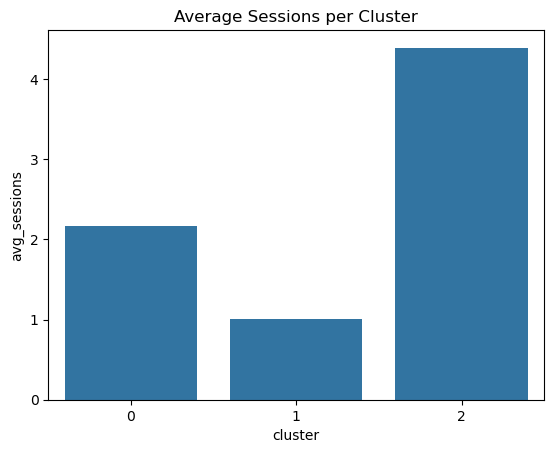

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=cluster_metrics.index, y=cluster_metrics['avg_sessions'])
plt.title('Average Sessions per Cluster')
plt.show()

## Elbow Method to Optimize k

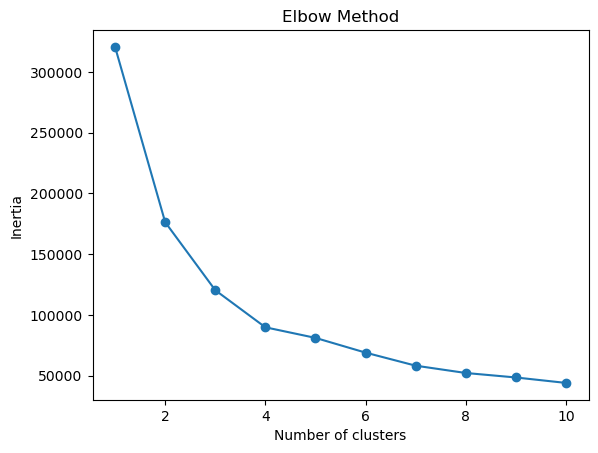

In [11]:
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Top 3 Applications

Gaming DL (Bytes)     6.285438e+13
Other DL (Bytes)      6.272357e+13
Youtube DL (Bytes)    1.732628e+12
dtype: float64


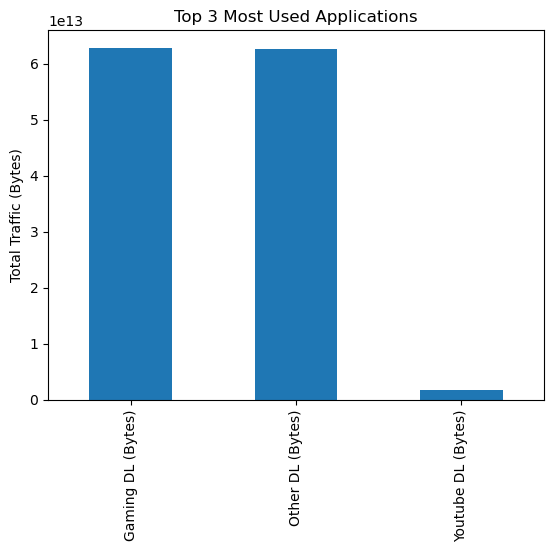

In [14]:
app_traffic = df_cleaned[['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
                    'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].sum()

top_apps = app_traffic.nlargest(3)

print(top_apps)

#plot the top 3
top_apps.plot(kind='bar')
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.show()